In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

#### Example bug rotation

[source](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html)

In [33]:
import numpy as np
import cv2 as cv
cap = cv.VideoCapture('data/experience/R25.mp4')
# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'MP4V')
out = cv.VideoWriter('data/rotation_bug.mp4', fourcc, 24.0, (1920, 1080))
i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
        
    # stop at ~6s
    if i > 150:
        break
    i += 1
    out.write(frame)
# Release everything if job is finished
cap.release()
out.release()

#### Transform video

In [2]:
video = VideoLoader('data/experience/R25/R25.mp4', gray=True, scale=(256, 256))
video.write('data/experience/R25/R25_gray_scaled.mp4')

#### params

In [2]:
ncomp = 50
skip_frame = 3
video = VideoLoader('data/experience/R25/R25_gray_scaled.mp4', gray=True, randit=True, skip_frame=skip_frame)
seed = 42

### PCA

In [18]:
model0 = custom_pca(ncomp)
video.batch_size = np.inf
video.torch = False

t1 = time()
for frames_fit in video:
    model0.fit(frames_fit)
t2 = time()

In [19]:
video.randit = video.skip_frame = 0
video.batch_size = 64
t3 = time()
reconstructed = video.reduce_latent(model0, trans=True)
t4 = time()

In [20]:
exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
      
print('Fitting time:', sec2string(t2-t1))
print('Transform time:', sec2string(t4-t3))
print('Reconstruction error:', exact_loss)

Fitting time: 20.86
Transform time: 9.18
Reconstruction error: 3.779316133573249


In [12]:
write_video('data/experience/R25/R25_pca_50.mp4', reconstructed, video.width, video.height, video.fps, True)

### PCA AE

In [22]:
print(PCAAutoEncoder((1, video.width, video.height), ncomp))

PCAAutoEncoder(
  (to_lower_rep): Linear(in_features=65536, out_features=50, bias=True)
  (from_lower_rep): Linear(in_features=50, out_features=65536, bias=True)
)


#### Tuning hyperparameters

In [9]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

all_losses = {}
for lr in [1e-6, 5e-6, 1e-5, 5e-5]:
    for wd in [0.00001, 0.001]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model1 = PCAAutoEncoder((1, video.width, video.height), ncomp)
        optimizer = Adam(model1.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model1.parameters()])}')
        
        losses = []
        for i in range(20):
            epoch_loss = 0
            nframe = 0
            for x in video:
                nframe += x.shape[0]
                x_reconstructed = model1(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
            losses.append(epoch_loss / nbatch)
            if (i+1) % 4 == 0:
                print(i+1, ':', losses[-1])
        all_losses[f'{lr}, {wd}'] = losses

ncomp -> 50, lr -> 1e-06, wd -> 1e-05, nparams -> 6619186
4 : 154.15550231933594
8 : 153.64275614420572
12 : 153.70300801595053
16 : 154.77449798583984
20 : 154.33246103922525
ncomp -> 50, lr -> 1e-06, wd -> 0.001, nparams -> 6619186
4 : 154.15557098388672
8 : 153.643185933431
12 : 153.7040252685547
16 : 154.7762222290039
20 : 154.3350346883138
ncomp -> 50, lr -> 5e-06, wd -> 1e-05, nparams -> 6619186
4 : 154.02500915527344
8 : 153.60043334960938
12 : 153.63640594482422
16 : 154.69534301757812
20 : 154.20664978027344
ncomp -> 50, lr -> 5e-06, wd -> 0.001, nparams -> 6619186
4 : 154.02528127034506
8 : 153.60211944580078
12 : 153.64096323649088
16 : 154.70486958821616
20 : 154.22391255696616
ncomp -> 50, lr -> 1e-05, wd -> 1e-05, nparams -> 6619186
4 : 154.1164321899414
8 : 153.58419291178384
12 : 153.58601888020834
16 : 154.61130015055338
20 : 154.0525385538737
ncomp -> 50, lr -> 1e-05, wd -> 0.001, nparams -> 6619186
4 : 154.11663564046225
8 : 153.58619435628256
12 : 153.59195709228516

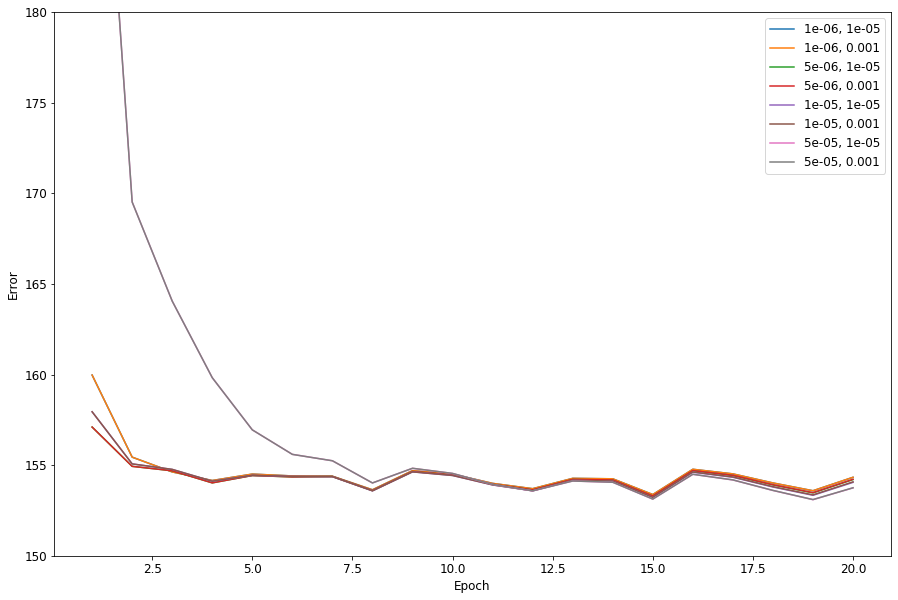

In [10]:
plot(range(1, 21), all_losses.values(), labels=all_losses.keys(), xlabel='Epoch', ylabel='Error', yrange=(150, 180))

In [123]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

all_losses = {}
for lr in [1e-8, 1e-7]:
    for wd in [0]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model1 = PCAAutoEncoder((1, video.width, video.height), ncomp)
        optimizer = Adam(model1.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model1.parameters()])}')
        
        losses = []
        for i in range(20):
            epoch_loss = 0
            nframe = 0
            for x in video:
                nframe += x.shape[0]
                x_reconstructed = model1(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
            losses.append(epoch_loss / nbatch)
            if (i+1) % 4 == 0:
                print(i+1, ':', losses[-1])
        all_losses[f'{lr}, {wd}'] = losses

ncomp -> 50, lr -> 1e-08, wd -> 0, nparams -> 6619186
4 : 162.2488047281901
8 : 161.72145334879556
12 : 161.4661382039388
16 : 162.33671061197916
20 : 161.5621109008789
ncomp -> 50, lr -> 1e-07, wd -> 0, nparams -> 6619186
4 : 159.89814249674478
8 : 157.5036392211914
12 : 156.14193979899088
16 : 156.3420842488607
20 : 155.32917022705078


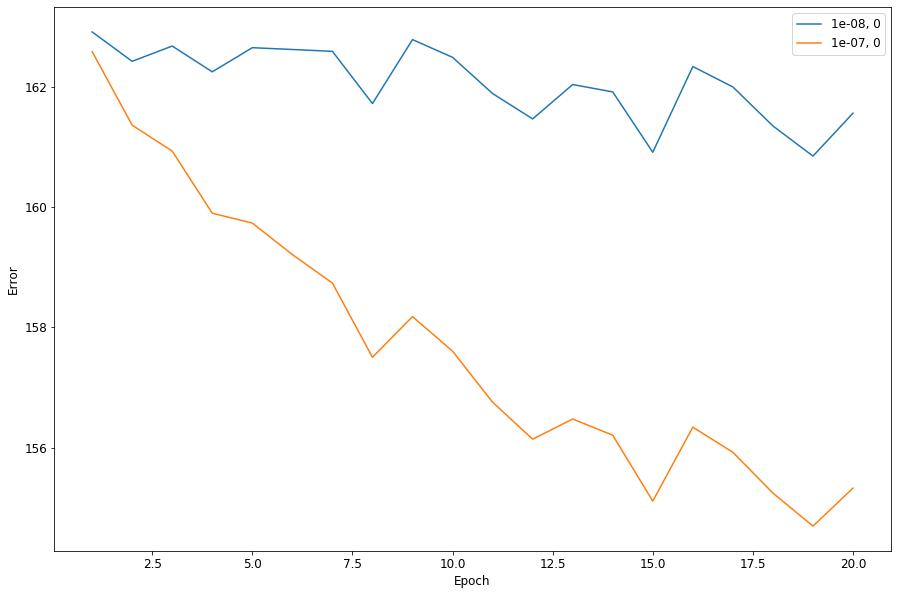

In [124]:
plot(range(1, 21), all_losses.values(), labels=all_losses.keys(), xlabel='Epoch', ylabel='Error')

#### Training

In [4]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

num_epoch = 30
lr, wd = 1e-5, 1e-5

torch.manual_seed(seed)
np.random.seed(seed)

model1 = PCAAutoEncoder((video.width, video.height), ncomp)
optimizer = Adam(model1.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model1.parameters()])}')

losses = []
t1 = time()
for i in range(num_epoch):
    epoch_loss = 0
    nframe = 0
    for x in video:
        nframe += x.shape[0]
        x_reconstructed = model1(x)
        batch_loss = crit(x_reconstructed, x.squeeze())
        epoch_loss += batch_loss.item()

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
    losses.append(epoch_loss / nbatch)
t2 = time()

video.randit = video.skip_frame = 0

print('Fitting time:', sec2string(t2-t1))

t3 = time()
exact_loss = reconstruction_error(video.reduce_latent(model1, trans=False).numpy(), video.get_all_frames().squeeze().numpy())
t4 = time()
print('Transform time:', sec2string(t4-t3))

print('Reconstruction error:', exact_loss)

ncomp -> 50, lr -> 1e-05, wd -> 1e-05, nparams -> 6619186
Fitting time: 1:58
Transform time: 21.32
Reconstruction error: 153.19435


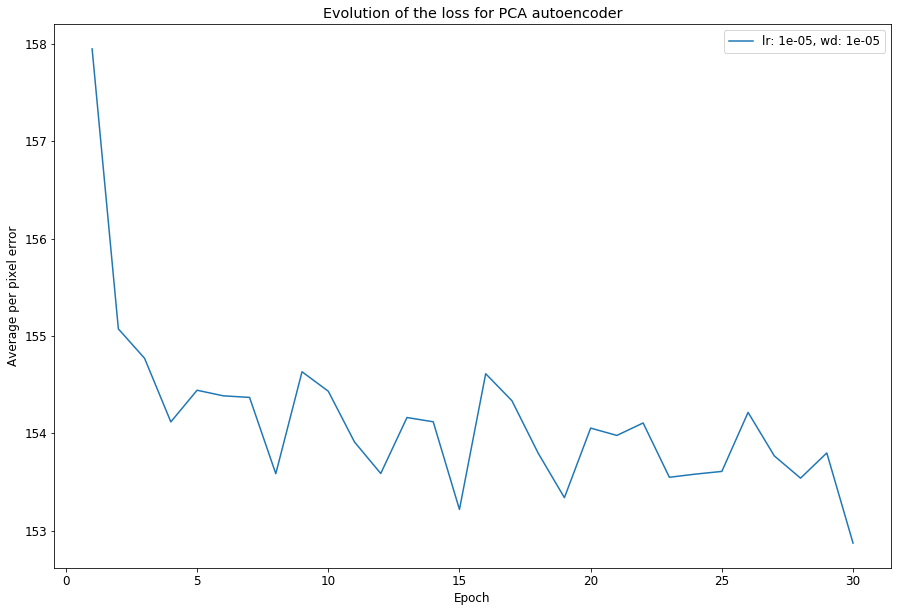

In [5]:
plot(range(1, num_epoch+1), [losses], xlabel='Epoch', ylabel='Average per pixel error', labels=[f'lr: {lr}, wd: {wd}'], title='Evolution of the loss for PCA autoencoder')

### One hidden AE

In [23]:
print(OneHAutoEncoder((1, video.width, video.height), ncomp))

OneHAutoEncoder(
  (to_lower_rep): Sequential(
    (0): Linear(in_features=65536, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=50, bias=True)
  )
  (from_lower_rep): Sequential(
    (0): Linear(in_features=50, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=65536, bias=True)
  )
)


#### Tuning hyperparameters

In [68]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

all_losses = {}
for lr in [0.01, 0.05, 0.1]:
    for wd in [0.00001, 0.001, 0.1]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model2 = OneHAutoEncoder((1, video.width, video.height), ncomp)
        optimizer = Adam(model2.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model2.parameters()])}')
        
        losses = []
        for i in range(16):
            epoch_loss = 0
            nframe = 0
            for x in video:
                nframe += x.shape[0]
                x_reconstructed = model2(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
            losses.append(epoch_loss / nbatch)
            if (i+1) % 4 == 0:
                print(i+1, ':', losses[-1])
        all_losses[f'{lr}, {wd}'] = losses

ncomp -> 50, lr -> 0.01, wd -> 1e-05, nparams -> 26300386
4 : 58.737717946370445
8 : 66.6867831548055
12 : 34.77551682790121
16 : 27.2652800877889
ncomp -> 50, lr -> 0.01, wd -> 0.001, nparams -> 26300386
4 : 68.01905695597331
8 : 68.51959705352783
12 : 85.42119598388672
16 : 153.92796834309897
ncomp -> 50, lr -> 0.01, wd -> 0.1, nparams -> 26300386
4 : 130.64633305867514
8 : 153.43597666422525
12 : 153.45957946777344
16 : 153.94463094075522
ncomp -> 50, lr -> 0.05, wd -> 1e-05, nparams -> 26300386
4 : 123.76015345255534
8 : 42.94698015848795
12 : 91.38638687133789
16 : 29.051170984903973
ncomp -> 50, lr -> 0.05, wd -> 0.001, nparams -> 26300386
4 : 2061.484448750814
8 : 12165.59543355306
12 : 153.44040171305338
16 : 153.93059794108072
ncomp -> 50, lr -> 0.05, wd -> 0.1, nparams -> 26300386
4 : 154.17327626546225
8 : 153.4357935587565
12 : 153.46000162760416
16 : 153.94550323486328
ncomp -> 50, lr -> 0.1, wd -> 1e-05, nparams -> 26300386
4 : 130.2346623738607
8 : 35.792409578959145
12 

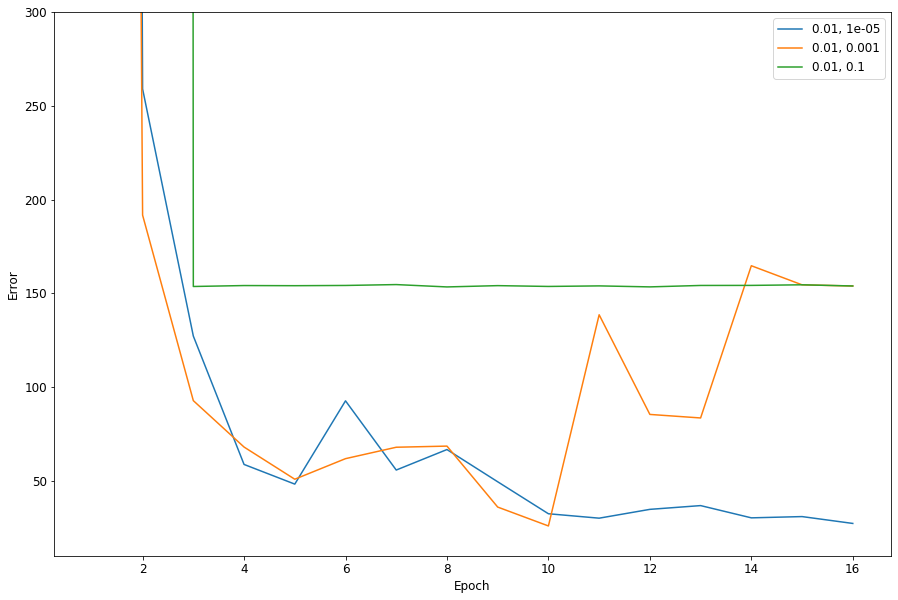

In [99]:
plot(range(1, 17), all_losses.values(), labels=all_losses.keys(), xlabel='Epoch', ylabel='Error', yrange=(10, 300), bound_to_plot=(6,200))

In [100]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

all_losses = {}
for lr in [1e-4, 1e-3, 1e-2]:
    for wd in [0.00001]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model2 = OneHAutoEncoder((1, video.width, video.height), ncomp)
        optimizer = Adam(model2.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model2.parameters()])}')
        
        losses = []
        for i in range(16):
            epoch_loss = 0
            nframe = 0
            for x in video:
                nframe += x.shape[0]
                x_reconstructed = model2(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
            losses.append(epoch_loss / nbatch)
            if (i+1) % 4 == 0:
                print(i+1, ':', losses[-1])
        all_losses[f'{lr}, {wd}'] = losses

ncomp -> 50, lr -> 0.0001, wd -> 1e-05, nparams -> 26300386
4 : 147.04139709472656
8 : 105.48971303304036
12 : 54.6549866994222
16 : 24.411142985026043
ncomp -> 50, lr -> 0.001, wd -> 1e-05, nparams -> 26300386
4 : 52.22380574544271
8 : 27.367934862772625
12 : 20.23192246754964
16 : 18.433344046274822
ncomp -> 50, lr -> 0.01, wd -> 1e-05, nparams -> 26300386
4 : 58.737717946370445
8 : 66.6867831548055
12 : 34.77551682790121
16 : 27.2652800877889
Fitting time: 4:14
Transform time: 23.18
Reconstruction error: 26.556362


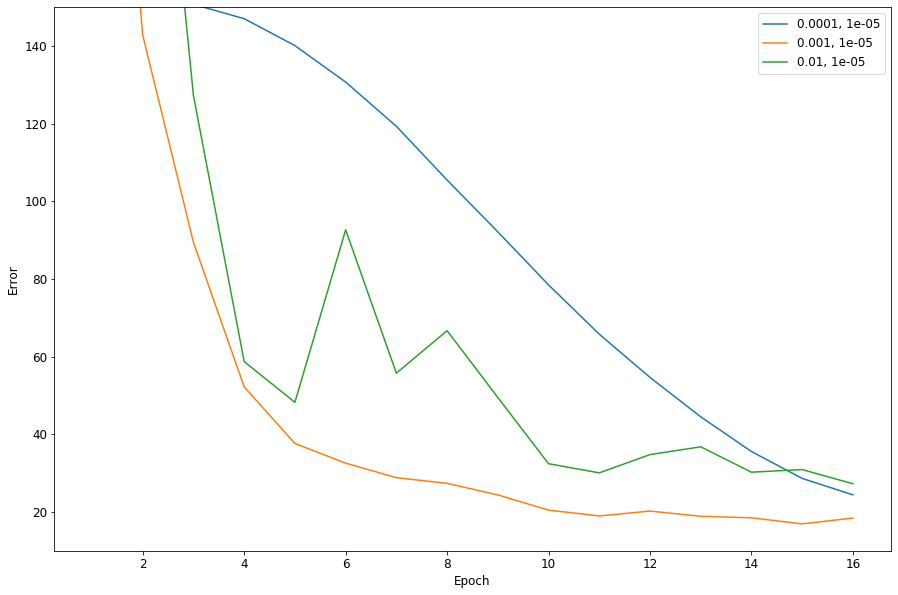

In [105]:
plot(range(1, 17), all_losses.values(), labels=all_losses.keys(), xlabel='Epoch', ylabel='Error', yrange=(10, 150))

In [106]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

all_losses = {}
for lr in [1e-3]:
    for wd in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model2 = OneHAutoEncoder((1, video.width, video.height), ncomp)
        optimizer = Adam(model2.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model2.parameters()])}')
        
        losses = []
        for i in range(16):
            epoch_loss = 0
            nframe = 0
            for x in video:
                nframe += x.shape[0]
                x_reconstructed = model2(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
            losses.append(epoch_loss / nbatch)
            if (i+1) % 4 == 0:
                print(i+1, ':', losses[-1])
        all_losses[f'{lr}, {wd}'] = losses

ncomp -> 50, lr -> 0.001, wd -> 0.0001, nparams -> 26300386
4 : 44.22795804341634
8 : 25.516353289286297
12 : 19.657039960225422
16 : 16.040268739064533
ncomp -> 50, lr -> 0.001, wd -> 0.001, nparams -> 26300386
4 : 55.466030756632485
8 : 23.74471918741862
12 : 20.59130096435547
16 : 16.06921100616455
ncomp -> 50, lr -> 0.001, wd -> 0.01, nparams -> 26300386
4 : 51.25335566202799
8 : 21.65696080525716
12 : 23.71334107716878
16 : 16.553901354471844
ncomp -> 50, lr -> 0.001, wd -> 0.1, nparams -> 26300386
4 : 59.349730809529625
8 : 29.021227836608887
12 : 20.06292661031087
16 : 16.33959945042928
ncomp -> 50, lr -> 0.001, wd -> 1, nparams -> 26300386
4 : 152.8207015991211
8 : 43.76432450612386
12 : 21.510237058003742
16 : 18.666310628255207


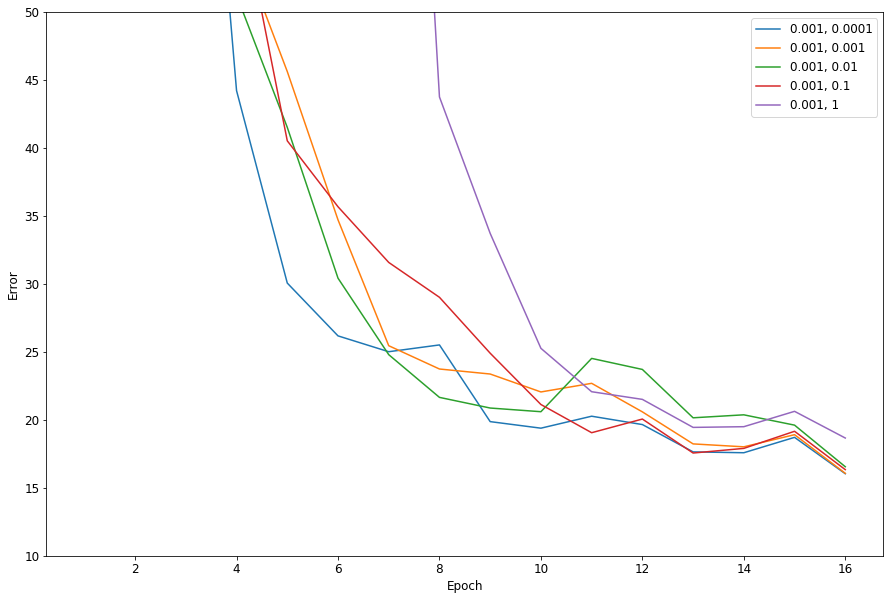

In [108]:
plot(range(1, 17), all_losses.values(), labels=all_losses.keys(), xlabel='Epoch', ylabel='Error', yrange=(10, 50))

#### Training

In [113]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

lr, wd = 1e-3, 1e-4
num_epoch = 40

torch.manual_seed(seed)
np.random.seed(seed)

model2 = OneHAutoEncoder((1, video.width, video.height), ncomp)
optimizer = Adam(model2.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model2.parameters()])}')

losses = []
t1 = time()
for i in range(num_epoch):
    epoch_loss = 0
    nframe = 0
    for x in video:
        nframe += x.shape[0]
        x_reconstructed = model2(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
    losses.append(epoch_loss / nbatch)
t2 = time()

video.randit = video.skip_frame = 0

print('Fitting time:', sec2string(t2-t1))

t3 = time()
exact_loss = reconstruction_error(video.reduce_latent(model2, trans=False).numpy(), video.get_all_frames().numpy())
t4 = time()
print('Transform time:', sec2string(t4-t3))

print('Reconstruction error:', exact_loss)

ncomp -> 50, lr -> 0.001, wd -> 0.0001, nparams -> 26300386
Fitting time: 3:31
Shapes don't match
Transform time: 21.98
Reconstruction error: -1


In [125]:
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model2.parameters()])}')
print('Fitting time:', sec2string(t2-t1))

t3 = time()
exact_loss = reconstruction_error(video.reduce_latent(model2, trans=False).numpy(), video.get_all_frames().numpy())
t4 = time()
print('Transform time:', sec2string(t4-t3))

print('Reconstruction error:', exact_loss)

ncomp -> 50, lr -> 1e-07, wd -> 0, nparams -> 26300386
Fitting time: 3:31
Transform time: 24.59
Reconstruction error: 17.074371


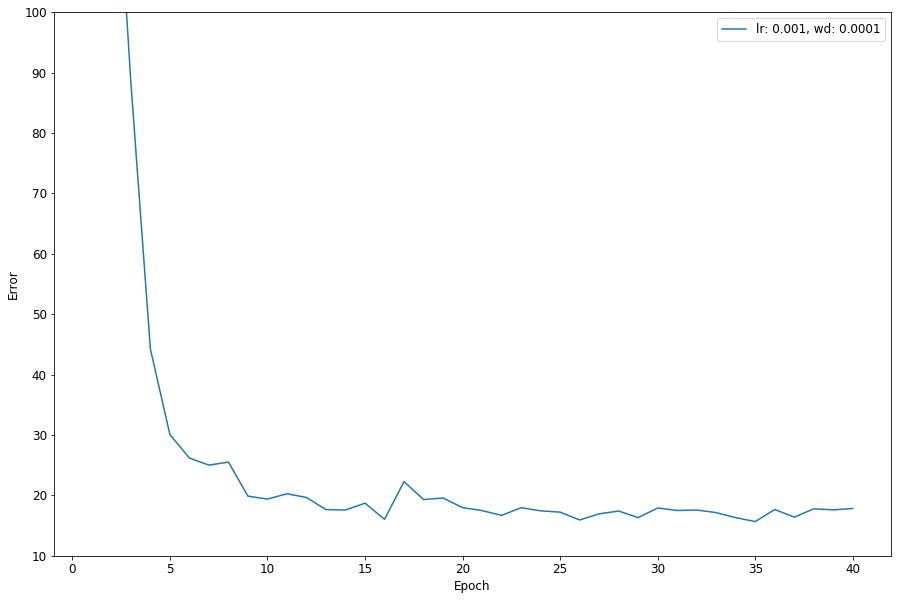

In [114]:
plot(range(1, num_epoch+1), [losses], labels=[f'lr: {lr}, wd: {wd}'], xlabel='Epoch', ylabel='Error', yrange=(10, 100))

### Spatial Convolutionnal AE

In [ ]:
m = SpatialConvAE(1, 50)
m(torch.ones((10*60*25, 1, 256, 256)))

In [24]:
print(SpatialConvAE(1, ncomp))

SpatialConvAE(
  (encoder_convs): Sequential(
    (0): Conv2d(1, 128, kernel_size=(26, 26), stride=(5, 5))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(11, 11), stride=(3, 3))
    (3): ReLU()
    (4): Conv2d(128, 64, kernel_size=(6, 6), stride=(1, 1))
    (5): ReLU()
  )
  (encoder_lin): Linear(in_features=4096, out_features=50, bias=True)
  (decoder_lin): Linear(in_features=50, out_features=4096, bias=True)
  (decoder_convs): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 128, kernel_size=(11, 11), stride=(3, 3))
    (3): ReLU()
    (4): ConvTranspose2d(128, 1, kernel_size=(26, 26), stride=(5, 5))
  )
)


SpatialConvAE(
  (encoder_convs): Sequential(
    (0): Conv2d(1, 128, kernel_size=(26, 26), stride = (2,2))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(11, 11), stride=(3, 3))
    (3): ReLU()
    (4): Conv2d(128, 64, kernel_size=(6, 6), stride=(1, 1))
    (5): ReLU()
  )
  (encoder_lin): Linear(in_features=4096, out_features=50, bias=True)
  (decoder_lin): Linear(in_features=50, out_features=4096, bias=True)
  (decoder_convs): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 128, kernel_size=(11, 11), stride=(3, 3))
    (3): ReLU()
    (4): ConvTranspose2d(128, 1, kernel_size=(26, 26), stride=(5, 5))
  )
)

#### Tuning hyperparameters

In [9]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

all_losses = {}
for lr in [1e-5, 1e-3, 1e-1]:
    for wd in [0]:
        torch.manual_seed(seed)
        np.random.seed(seed)
        model3 = SpatialConvAE(1, ncomp)
        optimizer = Adam(model3.parameters(), lr=lr, weight_decay=wd)
        print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model3.parameters()])}')
        
        losses = []
        for i in range(12):
            epoch_loss = 0
            nframe = 0
            for x in video:
                nframe += x.shape[0]
                x_reconstructed = model3(x)
                batch_loss = crit(x_reconstructed, x)
                epoch_loss += batch_loss.item()

                optimizer.zero_grad()
                batch_loss.backward()
                optimizer.step()

            nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
            losses.append(epoch_loss / nbatch)
            if (i+1) % 4 == 0:
                print(i+1, ':', losses[-1])
        all_losses[f'{lr}, {wd}'] = losses

ncomp -> 50, lr -> 1e-05, wd -> 0, nparams -> 5142131
4 : 151.75733184814453
8 : 118.11524073282878
12 : 100.64645767211914
ncomp -> 50, lr -> 0.001, wd -> 0, nparams -> 5142131
4 : 72.58752695719402
8 : 31.690513610839844
12 : 25.71382999420166
ncomp -> 50, lr -> 0.1, wd -> 0, nparams -> 5142131
4 : 152.46471405029297
8 : 150.0633290608724
12 : 147.92462412516275


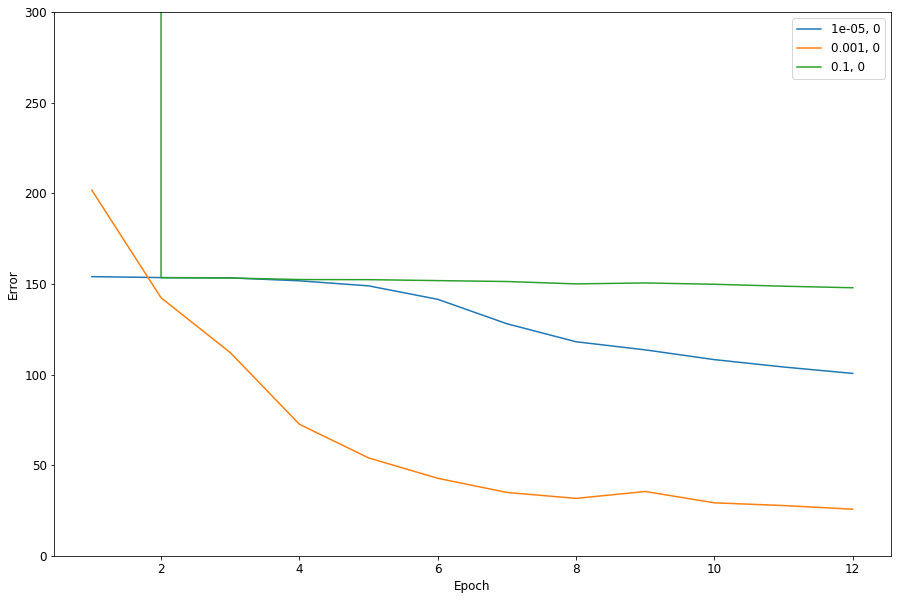

In [14]:
plot(range(1, 13), all_losses.values(), labels=all_losses.keys(), xlabel='Epoch', ylabel='Error', yrange=(0, 300))

#### Training

In [15]:
video.torch = True
video.batch_size = 64
video.randit = True
video.skip_frame = skip_frame

lr, wd = 1e-3, 0
num_epoch = 20

torch.manual_seed(seed)
np.random.seed(seed)

model3 = SpatialConvAE(1, ncomp)
optimizer = Adam(model3.parameters(), lr=lr, weight_decay=wd)
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in model3.parameters()])}')

losses = []
t1 = time()
for i in range(num_epoch):
    epoch_loss = 0
    nframe = 0
    for x in video:
        nframe += x.shape[0]
        x_reconstructed = model3(x)
        batch_loss = crit(x_reconstructed, x)
        epoch_loss += batch_loss.item()

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    nbatch = np.ceil(video.duration_frames / (video.batch_size * (video.skip_frame+1)))
    losses.append(epoch_loss / nbatch)
t2 = time()

video.randit = video.skip_frame = 0

print('Fitting time:', sec2string(t2-t1))

t3 = time()
exact_loss = reconstruction_error(video.reduce_latent(model3, trans=False).numpy(), video.get_all_frames().squeeze().numpy())
t4 = time()
print('Transform time:', sec2string(t4-t3))

print('Reconstruction error:', exact_loss)

ncomp -> 50, lr -> 0.001, wd -> 0, nparams -> 5142131
Fitting time: 10:27
Transform time: 59.72
Reconstruction error: -1


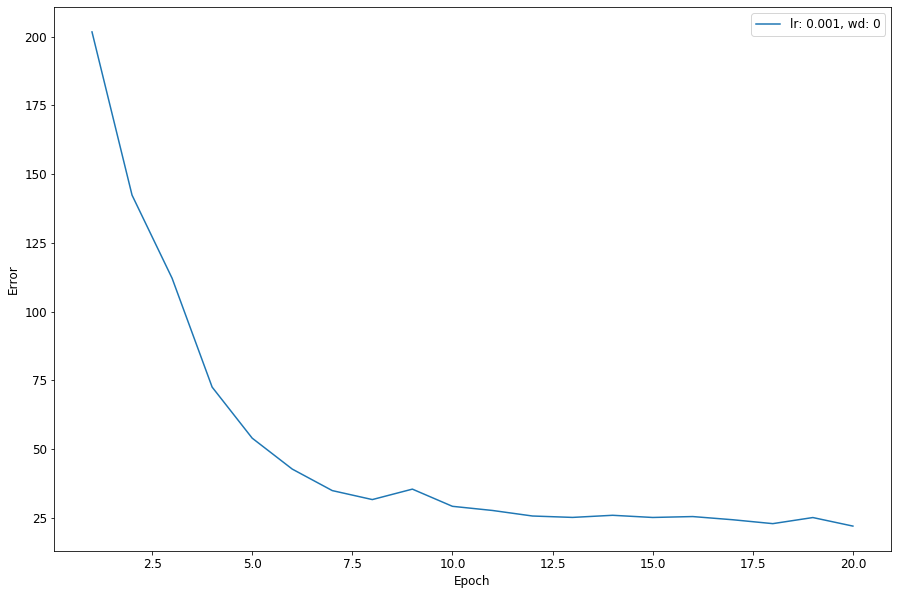

In [16]:
plot(range(1, num_epoch+1), [losses], labels=[f'lr: {lr}, wd: {wd}'], xlabel='Epoch', ylabel='Error')

# TRASH

In [26]:
import cv2
import numpy as np
# Create a VideoCapture object
cap = cv2.VideoCapture('data/experience/R25.mp4')

# Check if camera opened successfully
if (cap.isOpened() == False): 
    print("Unable to read camera feed")
# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('data/out_transpose.mp4',cv2.VideoWriter_fourcc(*"MP4V"), 24, (frame_height//2,frame_width//2), 0)
while(True):
    ret, frame = cap.read()
    if ret == True: 
        frame = np.transpose(frame, axes=[1,0, 2])
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Write the frame into the file 'output.avi'
        frame = cv2.resize(frame, (frame_height//2, frame_width//2), interpolation=cv2.INTER_AREA)
        out.write(frame)
    # Display the resulting frame
    # Press Q on keyboard to stop recording
  # Break the loop
    else:
        break 
# When everything done, release the video capture and video write objects
cap.release()
out.release()

In [17]:
cv2.destroyAllWindows()